# Payment Prediction ML

Guilherme Lupatelli <br>
guilherme.lupatelli@gmail.com <br>
https://www.linkedin.com/in/guilherme-lupatelli-520654b9/ <br>
May 2022

In [7]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')
sns.set_theme()
sns.set_style("whitegrid")

#data preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

#ML Modules
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.cluster import KMeans

#metrics
from sklearn.metrics import (
    log_loss,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score    
)
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import binary_ks_curve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

● The data files have the following attributes:
- customer_id - a unique id per customer
- order_nr - a unique identifier per order
- delivery_date - the date the order will be delivered (YYYYMMDD)
- delivery_week - the week the order will be delivered
- final_payment_status - whether the customer paid for the order after 10 weeks
- time_to_pay - the time between the failed payment and the customer paying for the order (no units)
- payment_method - the payment method on the customer's account that is charged each week
- custom_meal_selection - whether the customer chose their recipes for the week ("Yes") or received the default selection ("No")
- state - the state of the customer's delivery address
- channel - the marketing channel that the customer signed up through
- engagement_score - represents how engaged the customer is with the brand. Must be > 0.
- num_prior_orders_failed - the number of previous orders the customer had with a failed payment
- num_prior_orders_unpaid - the number of previous orders the customer had with a failed payment, that they didn't pay as at the time of the current failed order
- avg_recipe_rating - the average score the customer gave their past recipes


### Uploading datasets

I will upload the train and test data separately. For question 1 to 4 I will be using the train dataset, while for the question 5 I will be using the test data to make the final predictions with completely unseen data.

In [8]:
# uploading the datasets

df_train = pd.read_csv('training_data.csv')
df_test = pd.read_csv('test_data.csv')

In [9]:
# training data

df_train.head(10)

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating
0,5,19153,20200201,2020-W06,Paid,5.0,Z,Yes,B,O,13,4,0,NaN
1,13,10640,20200203,2020-W06,Paid,5.0,Z,Yes,B,O,222,98,0,NaN
2,15,373,20200201,2020-W06,Paid,5.0,Z,Yes,F,O,21,8,0,2.80
3,19,9285,20200203,2020-W06,Paid,15.0,Z,No,B,O,242,16,0,3.67
4,20,8669,20200203,2020-W06,Paid,22.0,W,Yes,B,O,14,5,1,NaN
5,23,4073,20200203,2020-W06,Paid,2.0,Z,Yes,B,O,11,1,0,NaN
6,26,3859,20200203,2020-W06,Paid,5.0,W,No,D,I,1,0,0,NaN
7,28,2169,20200203,2020-W06,Paid,22.0,Z,Yes,F,O,1,0,0,NaN
8,33,24460,20200203,2020-W06,Unpaid,NaN,X,Yes,G,O,1,0,0,NaN
9,36,10165,20200203,2020-W06,Paid,16.0,W,Yes,B,O,248,9,1,NaN


In [10]:
# test data

df_test.head(10)

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating
0,6,17266,20200229,2020-W10,Cancelled,NaN,X,Unknown,B,O,3,1,0,NaN
1,7,10494,20200301,2020-W10,Paid,15.0,W,Yes,D,O,29,14,0,4.00
2,8,10384,20200303,2020-W10,Paid,101.0,Z,Yes,B,S,17,9,0,NaN
3,9,3396,20200303,2020-W10,Paid,1.0,W,Yes,F,O,242,3,0,NaN
4,13,1146,20200302,2020-W10,Paid,22.0,Z,Yes,B,O,226,102,0,NaN
5,15,14774,20200229,2020-W10,Paid,4.0,Z,No,F,O,25,11,0,2.80
6,17,376,20200229,2020-W10,Paid,15.0,Z,Yes,F,S,1,0,0,NaN
7,18,8217,20200229,2020-W10,Paid,15.0,W,No,D,F2,9,10,0,3.67
8,46,3585,20200303,2020-W10,Paid,4.0,Z,Yes,B,O,297,9,1,NaN
9,51,16271,20200303,2020-W10,Paid,6.0,Z,No,D,O,12,1,0,2.75


### Checking general information about the dataset

Before creating a function for data checking and data cleaning, let me have an overview of `df_train` data, to see if there is any evident issue we can already spot.

In [11]:
# check stats

df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,19705.0,9.101808e+03,5179.131108,1.0,4656.00,9164.00,13577.0,17939.0
order_number,19705.0,1.236234e+04,7138.940813,1.0,6180.00,12344.00,18565.0,24704.0
delivery_date,19705.0,2.020021e+07,7.720309,20200201.0,20200208.00,20200215.00,20200222.0,20200226.0
time_to_pay,17763.0,3.425097e+01,87.133215,0.0,2.00,5.00,20.0,1000.0
engagement_score,19705.0,2.148470e+01,27.819352,-32.0,3.00,11.00,28.0,276.0
num_prior_orders_failed,19705.0,5.528242e+00,9.179146,0.0,0.00,2.00,7.0,101.0
num_prior_orders_unpaid,19705.0,2.002030e-01,0.570862,0.0,0.00,0.00,0.0,10.0
avg_recipe_rating,6180.0,3.506749e+00,0.549968,1.0,3.26,3.67,4.0,4.0


We can already spot some inconsistencies above, such as engagement score having the minimum value equals -32, where it should be greater than 0.

In [12]:
# check overall info

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19705 entries, 0 to 19704
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              19705 non-null  int64  
 1   order_number             19705 non-null  int64  
 2   delivery_date            19705 non-null  int64  
 3   delivery_week            19705 non-null  object 
 4   final_payment_status     19705 non-null  object 
 5   time_to_pay              17763 non-null  float64
 6   payment_method           19705 non-null  object 
 7   custom_meal_selection    19705 non-null  object 
 8   state                    19705 non-null  object 
 9   channel                  19705 non-null  object 
 10  engagement_score         19705 non-null  int64  
 11  num_prior_orders_failed  19705 non-null  int64  
 12  num_prior_orders_unpaid  19705 non-null  int64  
 13  avg_recipe_rating        6180 non-null   float64
dtypes: float64(2), int64(6

Above, we can notice that:
- `delivery_date` has Dtype = int64, while it should have datetime format;
- There are missing value on `time_to_pay` and `avg_recipe_rating`.

In [13]:
# check null values

df_train.isna().sum()

customer_id                    0
order_number                   0
delivery_date                  0
delivery_week                  0
final_payment_status           0
time_to_pay                 1942
payment_method                 0
custom_meal_selection          0
state                          0
channel                        0
engagement_score               0
num_prior_orders_failed        0
num_prior_orders_unpaid        0
avg_recipe_rating          13525
dtype: int64

# 1. Performing data cleaning and checking data accuracy

### a. Function to check data quality

Let's now create a function that will be able to check many data quality params. The idea is to reuse the function at the time I will use the test data, i.e., all the modifications and corrections I will make on the train data, I will also need to make it for test data before making predictions with my model.

In [14]:
def data_quality(df_q):
    
    print('The dataset contais', df_q.shape[0], 'rows and', df_q.shape[1], 'columns\n')
    print('Missing values:\n')
    
    # missing values
    for i in df_q.columns:
        if df_q[i].isna().sum() > 0:
            print('The column', i, 'contains', df_q[i].isna().sum(), 'null values (',
                  round(100*df_q[i].isna().sum()/df_q.shape[0],2), '% )')
    print('\n')
    
    # check duplicates
    print('Duplicated rows:\n')
    print('There is/are', df_q.duplicated().sum(), 'duplicated row(s)')
    print('\n')
            
    # unique values of some categorical features
    print('Unique values of some categorical features:\n')
    df_q_cat = df_q[['final_payment_status', 'payment_method', 'custom_meal_selection', 'state', 'channel']]
    for i in df_q_cat.columns:
        print('The column', i, 'has the following unique values:', df_q_cat[i].unique())
    print('\n')
    
    # check how many data in state is out of standard
    print('Checking state unique value counts:\n')
    print(df_q.state.value_counts())
    print('\n')
    
    # check max and min values of some numeric features
    print('Unique values of some numerical features:\n')
    df_q_num = df_q[['time_to_pay', 'engagement_score', 'num_prior_orders_failed',
                     'num_prior_orders_unpaid', 'avg_recipe_rating']]
    for i in df_q_num.columns:
        print('The column', i, 'has min and max values as: (', df_q_num[i].min(), 'to', df_q_num[i].max(), ')')
    print('\n')
        
    # check how many data in engagement_score equal or under 0 (must be >0)
    print('Checking engagement scores under or equal 0:\n')
    print(df_q[df_q.engagement_score <= 0].engagement_score.value_counts())

In [15]:
data_quality(df_train)

The dataset contais 19705 rows and 14 columns

Missing values:

The column time_to_pay contains 1942 null values ( 9.86 % )
The column avg_recipe_rating contains 13525 null values ( 68.64 % )


Duplicated rows:

There is/are 0 duplicated row(s)


Unique values of some categorical features:

The column final_payment_status has the following unique values: ['Paid' 'Unpaid' 'Cancelled' 'Other' 'Refunded']
The column payment_method has the following unique values: ['Z' 'W' 'X' 'V' 'Y']
The column custom_meal_selection has the following unique values: ['Yes' 'No' 'Unknown']
The column state has the following unique values: ['B' 'F' 'D' 'G' 'A' 'E' 'C' '<error>' 'New York' '18' 'Turkey' 'Moscow'
 '25']
The column channel has the following unique values: ['O' 'I' 'H' 'A1' 'S' 'F2' 'D' 'E' 'F1' 'P' 'F3' 'A2']


Checking state unique value counts:

F           5124
B           5008
D           4777
G           2903
E           1259
A            421
C            192
<error>       15
New York    

Let's interpret the data quality results above:
- There are 19705 rows and 14 columns on the original train dataset;
- There is no duplicated row;
- The column `state` has some inconsistencies, such as numbers and original city names, however the number of inconsistencies is lower, represented by 21 cases;
- For numerical values, as already spotted before, there is an inconsistence with `engagement_score`, since it contais zeros and negative numbers and this feature must contain only values greater than zero.

### b. Function to perform data cleaning

Now that I have already done the function to check data quality, let's jump to data cleaning:
- Missing values: I will fill `time_to_pay` null values with values 10 times higher than its maximum to be able to differentiate this specific condition where the payment is not done. For `avg_recipe_rating` null values, i.e. when users do not rate any recipe, I will assume that they are not satisfacted with the recipe. It's fare to say that a client will rate the recipe only when they really enjoyed or disliked some product;
- Dropping `state` rows out of standard: I will be removing all the inconsist states and will assume that correct states are represented by a single capital letter from 'A' to 'G';
- Dropping `engagement score` rows out of standard: I will drop rows where `engagement_score` <= 0;
- Correcting `delivery_date` format: I will correct the format from int64 to datetime.

In [16]:
def data_clean(df_c):
    
    # dropping states out of standard
    df_c = df_c[(df_c.state == 'A') | (df_c.state == 'B') | (df_c.state == 'C') | (df_c.state == 'D') |
                (df_c.state == 'E') | (df_c.state == 'F') | (df_c.state == 'G')]
    
    # dropping engagement scores under or equal 0
    df_c = df_c[df_c.engagement_score > 0]
    
    # correcting delivery_date format
    df_c['delivery_date'] = df_c['delivery_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    
    return df_c
    

In [17]:
df_train = data_clean(df_train)

In [18]:
df_train.head(10)

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating
0,5,19153,2020-02-01,2020-W06,Paid,5.0,Z,Yes,B,O,13,4,0,NaN
1,13,10640,2020-02-03,2020-W06,Paid,5.0,Z,Yes,B,O,222,98,0,NaN
2,15,373,2020-02-01,2020-W06,Paid,5.0,Z,Yes,F,O,21,8,0,2.80
3,19,9285,2020-02-03,2020-W06,Paid,15.0,Z,No,B,O,242,16,0,3.67
4,20,8669,2020-02-03,2020-W06,Paid,22.0,W,Yes,B,O,14,5,1,NaN
5,23,4073,2020-02-03,2020-W06,Paid,2.0,Z,Yes,B,O,11,1,0,NaN
6,26,3859,2020-02-03,2020-W06,Paid,5.0,W,No,D,I,1,0,0,NaN
7,28,2169,2020-02-03,2020-W06,Paid,22.0,Z,Yes,F,O,1,0,0,NaN
8,33,24460,2020-02-03,2020-W06,Unpaid,NaN,X,Yes,G,O,1,0,0,NaN
9,36,10165,2020-02-03,2020-W06,Paid,16.0,W,Yes,B,O,248,9,1,NaN


With data cleaning done, I will move on to the EDA

# 2. EDA (exploratory Data Analysis)

### a. Evaluating `final_payment_status` and `time_to_pay`

In [19]:
def chart_a(df_chart):
    
    f, ax = plt.subplots(figsize=(15,10))

    total = float(len(df_chart))

    # creating countplots for final_payment_status
    plt.subplot(3, 1, 1)
    ax = sns.countplot(x=df_chart.final_payment_status)
    plt.title('1) Final Payment Status (Target variable)')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.subplot(3, 1, 2)
    ax = sns.countplot(data=df_chart[df_chart.final_payment_status != 'Paid'], x='final_payment_status',
                      palette=['C1', 'C2', 'C3', 'C4'])
    plt.title('2) Final Payment Status without Paid')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')

    plt.tight_layout()
    
    f, ax = plt.subplots(figsize=(15,10))

    # creating histograms for time_to_pay
    plt.subplot(2, 1, 1)
    ax = sns.histplot(x=df_chart.time_to_pay)
    plt.xlim(0,100)
    plt.title('3) Time to pay distribution [0-100]')
    plt.subplot(2, 1, 2)
    ax = sns.countplot(x=df_chart.time_to_pay)
    plt.xlim(0,40)
    plt.xticks(rotation=75)
    plt.title('4) Time to pay [0-40]')

    plt.tight_layout()
    
    f, ax = plt.subplots(figsize=(15,5))

    p25 = df_chart['time_to_pay'].quantile(0.25)
    p75 = df_chart['time_to_pay'].quantile(0.75)

    # creating boxplots to have a better look into time_to_pay
    plt.subplot(1, 3, 1)
    ax = sns.boxplot(data=df_chart, y='time_to_pay', showfliers = True, showmeans=True)
    plt.title('5) Time to pay with outliers')
    plt.subplot(1, 3, 2)
    ax = sns.boxplot(data=df_chart, y='time_to_pay', showfliers = False, showmeans=True)
    plt.title('6) Time to pay with no outliers')
    plt.subplot(1, 3, 3)
    ax = sns.boxplot(data=df_chart[(df_chart.time_to_pay > 1.5*(p75-p25)) & (df_chart.time_to_pay != 10000)],
                     y='time_to_pay', showfliers = False, showmeans=True)
    plt.title('7) Time to pay only outliers')

    plt.tight_layout()

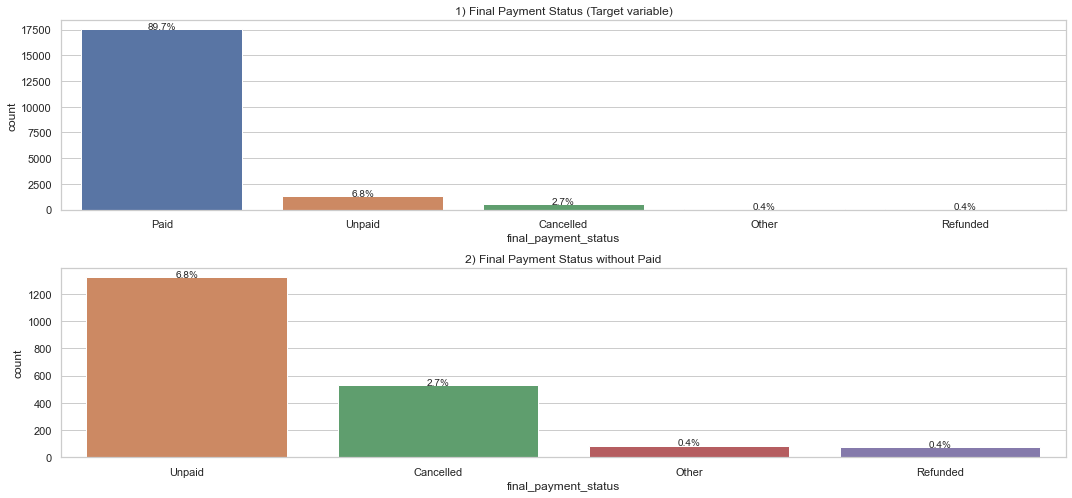

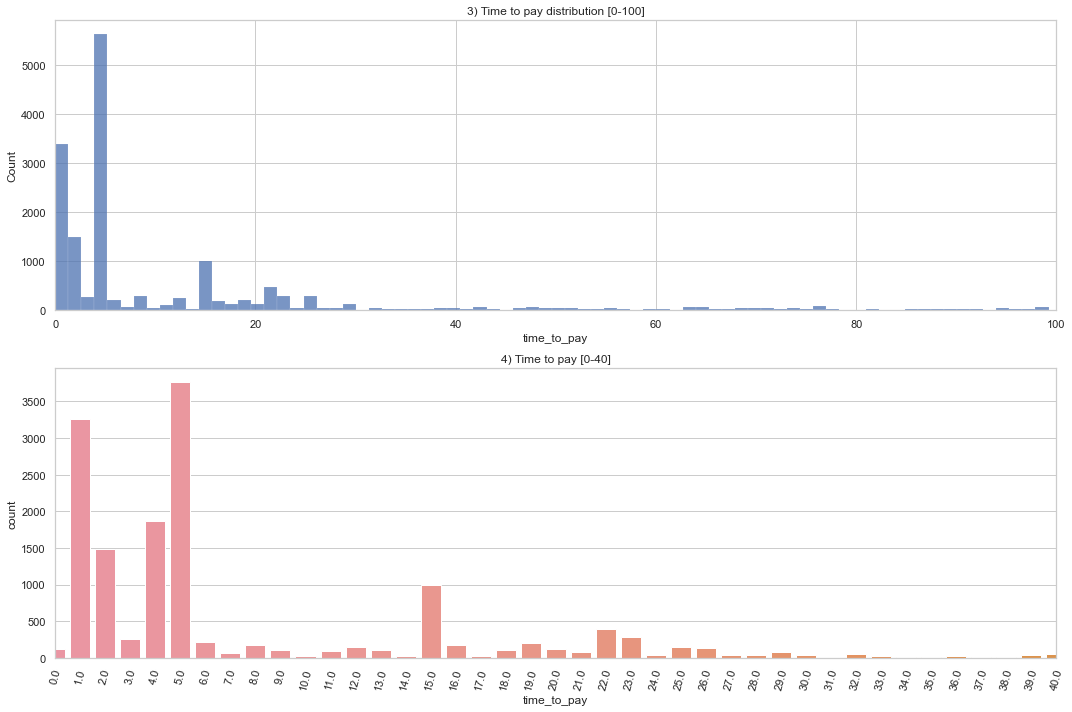

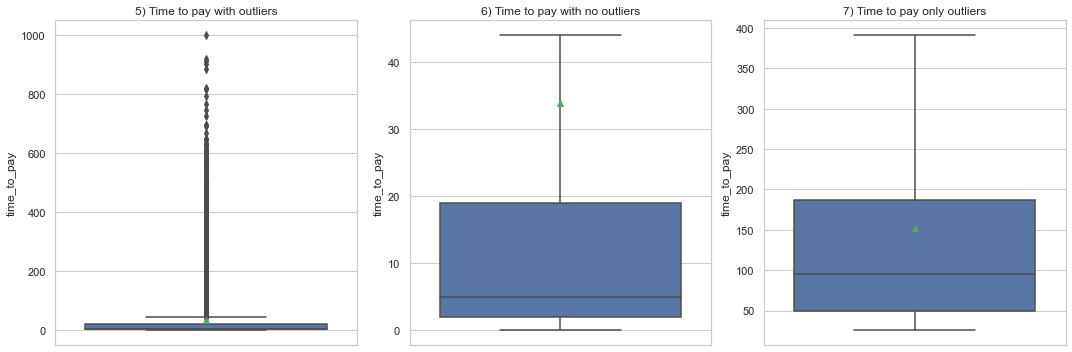

In [20]:
chart_a(df_train)

From above charts we can infer the following:
- First two charts (1 and 2) about `final_payment_status` is showing us that 90% of the train dataset has Paid status, while the remaining status account for 10%, with Unpaid being the highest;
- On the histograms (3 and 4) about `time_to_pay`we can notice that the highest concentration is around 1 to 2 and 4 to 5, with some small peaks around 15 and 22. This means that most of the users are paying relatively close to the time when the payment had failed;
- Last three boxplots (5, 6 and 7) are showing us the distribution behavior by analyzing it with and without outliers. The average around 34 is quite far from the median, which is caused by high outlier numbers as we can see on the left boxplot.

### b. Evaluating `engagement_score` and `final_payment_status`

### c. Evaluating `number_prior_orders_unpaid`, `custom_meal_selection`, `channel` vs. `final_payment_status`

First, let's bucket customers based on the `engagement_score`

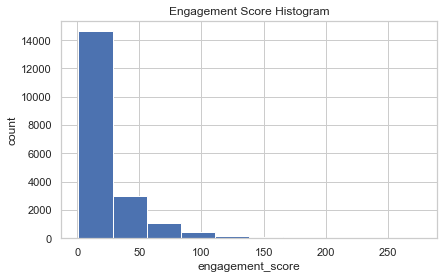

In [21]:
df_train['engagement_score'].hist()
plt.title('Engagement Score Histogram')
plt.xlabel('engagement_score')
plt.ylabel('count')
plt.show()

In [22]:
# checking the quantiles of engagement_score

df_train['engagement_score'].quantile([0.25,0.5,0.75, 0.9])

0.25     3.0
0.50    12.0
0.75    29.0
0.90    54.0
Name: engagement_score, dtype: float64

I will use the median as a threshold to bucket High/Low engagement scores.

In [23]:
# defining a function to bucket engagement_score

def engagement_cat(n):
    if n < 12:
        return 'Low'
    elif n >= 12:
        return 'High'

In [24]:
# applying the engagement_cat function

df_train['engagement_cat'] = df_train['engagement_score'].apply(engagement_cat)

In [25]:
def chart_bc(df_chart):
    
    f, ax = plt.subplots(figsize=(10,10))

    total = float(len(df_chart))

    # creating countplots charts to examine the relationship between engagement_score and the target variable over engagement_score_cat
    plt.subplot(3, 1, 1)
    ax = sns.countplot(x=df_chart.final_payment_status, hue=df_chart.engagement_cat)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('8) Engagement Score vs Final Payment Status\n')
    plt.subplot(3, 1, 2)
    ax = sns.countplot(data=df_chart[df_chart.final_payment_status != 'Paid'], x='final_payment_status', 
                       hue='engagement_cat', hue_order=('High', 'Low'))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('9) Engagement Score vs Final Payment Status [not Paid]\n')
    
    plt.tight_layout()

    # creating boxplot to check the paid status orders over the time to pay
    f, ax = plt.subplots(figsize=(10,10))

    total = float(len(df_chart))

    plt.subplot(1, 1, 1)
    ax = sns.boxplot(data=df_chart[df_chart.final_payment_status == 'Paid'], x='final_payment_status', y='time_to_pay',
                     hue='engagement_cat', showfliers = False, showmeans=True, palette=["C0", "C1"])
    plt.title('10) Time to Pay vs Final Payment Status [engagement_score_cat]\n')
    
    plt.tight_layout()
    
    # creating countplots to examine channel vs final_payment_status over engagement_score_cat
    f, ax = plt.subplots(figsize=(10,10))

    plt.subplot(3, 1, 1)
    ax = sns.countplot(data=df_chart[df_chart.final_payment_status == 'Paid'], x='channel', 
                       hue='engagement_cat', palette=["C0", "C1"], order=['O','I','H','A1','A2','S','F1','F2','F3','D','E','P'])
    plt.title('11) Channel vs Payment Status [Paid]\n')
    plt.legend(loc='upper right')
    plt.subplot(3, 1, 2)
    ax = sns.countplot(data=df_chart[(df_chart.final_payment_status != 'Paid') & (df_chart.engagement_cat == 'Low')],
                     x='channel', hue='final_payment_status', order=['O','I','H','A1','A2','S','F1','F2','F3','D','E','P'])
    plt.title('12) Channel vs Payment Status [not Paid & low engagement]\n')
    plt.legend(loc='upper right')
    plt.subplot(3, 1, 3)
    ax = sns.countplot(data=df_chart[(df_chart.final_payment_status != 'Paid') & (df_chart.engagement_cat == 'High')],
                     x='channel', hue='final_payment_status', hue_order=['Unpaid','Cancelled','Other','Refunded'],
                     order=['O','I','H','A1','A2','S','F1','F2','F3','D','E','P'])
    plt.title('13) Channel vs Payment Status [not Paid & high engagement]\n')
    plt.legend(loc='upper right')

    plt.tight_layout()
    
    # creating countplots to examine custom_meal_selection vs final_payment_status over engagement_score_cat
    f, ax = plt.subplots(figsize=(10,10))

    total = float(len(df_chart))

    plt.subplot(3, 1, 1)
    ax = sns.countplot(data=df_chart[df_chart.final_payment_status == 'Paid'], x='custom_meal_selection', 
                       hue='engagement_cat', palette=["C0", "C1"], order=['Yes', 'No', 'Unknown'])
    plt.legend(loc='upper right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('14) Custom Meal Selection vs Payment Status [Paid]\n')
    plt.subplot(3, 1, 2)
    ax = sns.countplot(data=df_chart[(df_chart.final_payment_status != 'Paid') & (df_chart.engagement_cat == 'Low')],
                     x='custom_meal_selection', hue='final_payment_status', order=['Yes', 'No', 'Unknown'],
                      palette=["C0", "C1", "C2", "C3"])
    plt.legend(loc='upper right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('15) Custom Meal Selection vs Payment Status [not Paid & low engagement]\n')
    plt.subplot(3, 1, 3)
    ax = sns.countplot(data=df_chart[(df_chart.final_payment_status != 'Paid') & (df_chart.engagement_cat == 'High')],
                     x='custom_meal_selection', hue='final_payment_status', order=['Yes', 'No', 'Unknown'],
                      palette=["C0", "C1", "C2", "C3"], hue_order=['Unpaid', 'Cancelled', 'Other', 'Refunded'])
    plt.legend(loc='upper right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('16) Custom Meal Selection vs Payment Status [not Paid & high engagement]\n')

    plt.tight_layout()
    
    # creating countplots to examine num_prior_orders_unpaid vs final_payment_status over engagement_score_cat
    f, ax = plt.subplots(figsize=(10,10))

    total = float(len(df_chart))

    plt.subplot(3, 1, 1)
    ax = sns.countplot(data=df_chart[df_chart.final_payment_status == 'Paid'], x='num_prior_orders_unpaid', 
                       hue='engagement_cat')
    plt.legend(loc='upper right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('17) Num Pior Unpaid vs Payment Status [Paid]\n')
    plt.subplot(3, 1, 2)
    ax = sns.countplot(data=df_chart[(df_chart.final_payment_status != 'Paid') & (df_chart.engagement_cat == 'Low')],
                     x='num_prior_orders_unpaid', hue='final_payment_status', hue_order=['Unpaid', 'Cancelled', 'Other', 'Refunded'])
    plt.legend(loc='upper right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('18) Num Pior Unpaid vs Payment Status [not Paid & low engagement]\n')
    plt.subplot(3, 1, 3)
    ax = sns.countplot(data=df_chart[(df_chart.final_payment_status != 'Paid') & (df_chart.engagement_cat == 'High')],
                     x='num_prior_orders_unpaid', hue='final_payment_status', hue_order=['Unpaid', 'Cancelled', 'Other', 'Refunded'])
    plt.legend(loc='upper right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')
    plt.title('19) Num Pior Unpaid vs Payment Status [not Paid & high engagement]\n')

    plt.tight_layout()

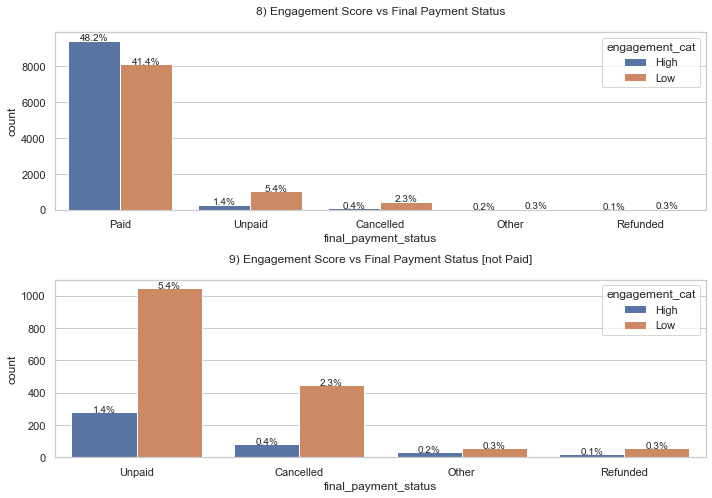

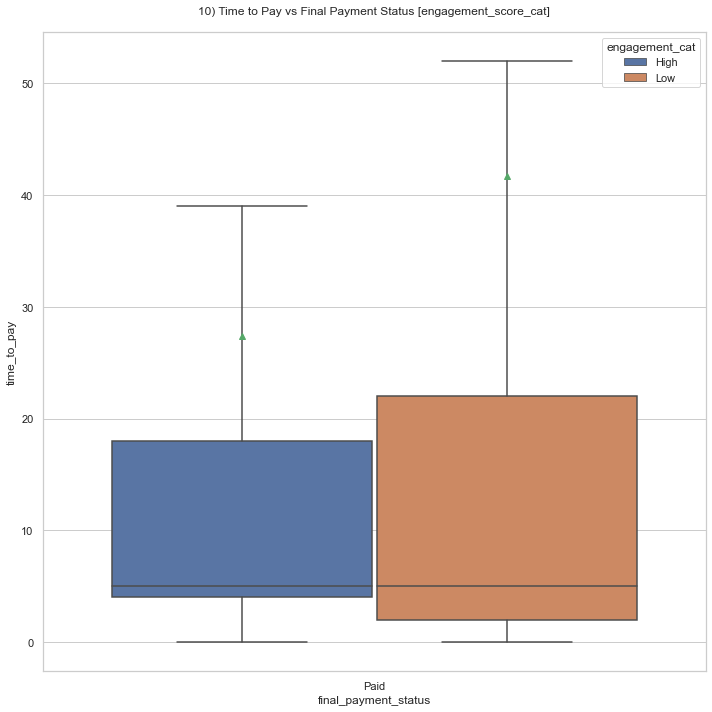

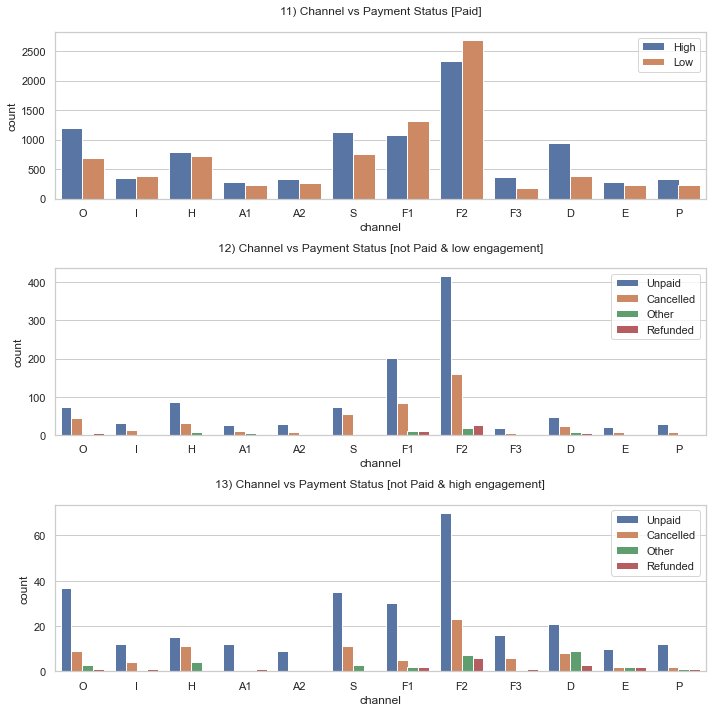

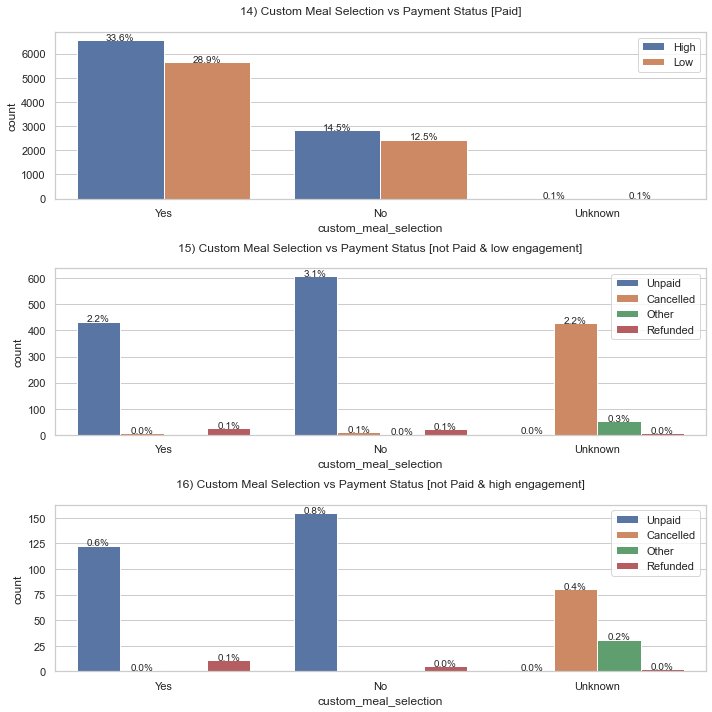

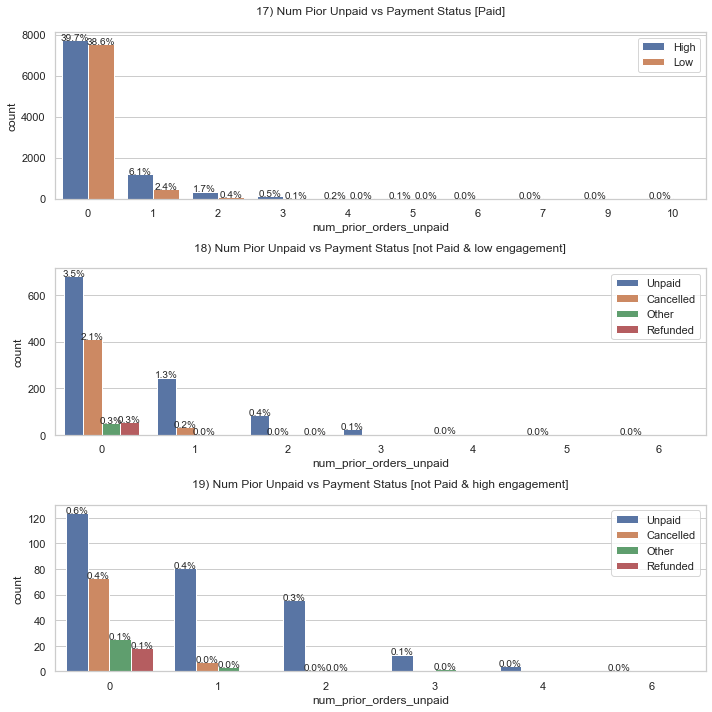

In [26]:
chart_bc(df_train)

From above charts we can infer the following:
- We have a slightly higher number of orders paid for high engaged customers as we can see on chart 8, however this relationship will change accordingly with the engagement score threshold, which was set to 12 (median). Besides that, when we look to the remaining status on chart 9, we can see a high concentration of orders from low engaged users;
- From the boxplot (chart 10) comparing paid status cases and time to pay over engagement, we are able to see that the average time to pay is hiher for low engaged clients and as higher time to pay, higher will be the difference among low and high engaged cases;
- On the chart 11, looking just to paid orders over channel, we can notice that F1, F2 and I are showing the opposite trend compared to the other channels. These 3 channels curiously have higher number of paid orders for low engagement than high. When we compare high and low engagement cases on charts 12 and 13 we can see a quite similar trend for both scenarios, with some differences for channels D and O but nothing very significant;
- On the chart 14, high engaged customers are paying slightly more, regardless meal selection. Same trend is observed on the following charts 15 and 16 representing custom meal selection vs non paid status for low and high engagement scores;
- Chart 17 is showing us that most of the users on this dataset never had an unpaid order before and it is showing quite similar trend over charts 18 and 19 when we compare non paid status and low/high engagement.

# 3. Feature Engineering

### a. Writing a function to create an `ever_rated_recipe` binary feature based on the `avg_recipe_rating`

### b. Using the function to create an `is_f` binary feature based on the `channel` including (F1 and F2)

In [27]:
# function to create ever_rated_recipe and is_f binary columns

def feature_c(df_in):
    df_in['ever_rated_recipe'] = ~ df_in['avg_recipe_rating'].isnull()
    df_in['is_f'] = df_in['channel'].isin(['F1','F2'])

In [28]:
feature_c(df_train)

In [29]:
df_train.head(10)

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating,engagement_cat,ever_rated_recipe,is_f
0,5,19153,2020-02-01,2020-W06,Paid,5.0,Z,Yes,B,O,13,4,0,NaN,High,False,False
1,13,10640,2020-02-03,2020-W06,Paid,5.0,Z,Yes,B,O,222,98,0,NaN,High,False,False
2,15,373,2020-02-01,2020-W06,Paid,5.0,Z,Yes,F,O,21,8,0,2.80,High,True,False
3,19,9285,2020-02-03,2020-W06,Paid,15.0,Z,No,B,O,242,16,0,3.67,High,True,False
4,20,8669,2020-02-03,2020-W06,Paid,22.0,W,Yes,B,O,14,5,1,NaN,High,False,False
5,23,4073,2020-02-03,2020-W06,Paid,2.0,Z,Yes,B,O,11,1,0,NaN,Low,False,False
6,26,3859,2020-02-03,2020-W06,Paid,5.0,W,No,D,I,1,0,0,NaN,Low,False,False
7,28,2169,2020-02-03,2020-W06,Paid,22.0,Z,Yes,F,O,1,0,0,NaN,Low,False,False
8,33,24460,2020-02-03,2020-W06,Unpaid,NaN,X,Yes,G,O,1,0,0,NaN,Low,False,False
9,36,10165,2020-02-03,2020-W06,Paid,16.0,W,Yes,B,O,248,9,1,NaN,High,False,False


# 4. Training the Machine Learning model

Treating orders with payment status of Cancelled, Refunded or Other as Paid

In [30]:
# creating a binary target variable

def target_bin(n):
    if n in ('Unpaid'):
        return 0
    else:
        return 1

In [31]:
df_train['target'] = df_train['final_payment_status'].apply(target_bin)

In [32]:
df_train.head(10)

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating,engagement_cat,ever_rated_recipe,is_f,target
0,5,19153,2020-02-01,2020-W06,Paid,5.0,Z,Yes,B,O,13,4,0,NaN,High,False,False,1
1,13,10640,2020-02-03,2020-W06,Paid,5.0,Z,Yes,B,O,222,98,0,NaN,High,False,False,1
2,15,373,2020-02-01,2020-W06,Paid,5.0,Z,Yes,F,O,21,8,0,2.80,High,True,False,1
3,19,9285,2020-02-03,2020-W06,Paid,15.0,Z,No,B,O,242,16,0,3.67,High,True,False,1
4,20,8669,2020-02-03,2020-W06,Paid,22.0,W,Yes,B,O,14,5,1,NaN,High,False,False,1
5,23,4073,2020-02-03,2020-W06,Paid,2.0,Z,Yes,B,O,11,1,0,NaN,Low,False,False,1
6,26,3859,2020-02-03,2020-W06,Paid,5.0,W,No,D,I,1,0,0,NaN,Low,False,False,1
7,28,2169,2020-02-03,2020-W06,Paid,22.0,Z,Yes,F,O,1,0,0,NaN,Low,False,False,1
8,33,24460,2020-02-03,2020-W06,Unpaid,NaN,X,Yes,G,O,1,0,0,NaN,Low,False,False,0
9,36,10165,2020-02-03,2020-W06,Paid,16.0,W,Yes,B,O,248,9,1,NaN,High,False,False,1


### Treating categorical features as numerical  for the model

Now I am going to do a trick for the class features. The idea is to give a number for each class, given its probability of the order being paid, i.e., as higher the probability of the classes, higher will be the number (from 0 to length-1).

In [33]:
# this function will be able to select all categorical features and pass them into numeric as mentioned above

def cat_features(df_cat):

    for i in df_cat.filter(['delivery_week', 'payment_method',
                            'custom_meal_selection', 'state', 'channel',
                            'target'], axis=1).columns:
        
        z = pd.crosstab(df_cat[i], df_cat['target']).apply(lambda row: row/row.sum(), axis=1)
        z = z.reset_index()
        z = z.rename_axis(index=None, columns=None)
        z = z.rename(columns={0:"target_0", 1:"target_1"})
        z = z.sort_values(by=["target_1"])
        distinct_z = [x for x in z[i].unique()]
        z_domain = dict(zip(distinct_z, range(0,len(distinct_z))))
        z[i+'_new'] = z[i].map(lambda x : z_domain[x])
        z = z[[i, i+'_new']]
        df_cat = df_cat.merge(z, on = i, how = 'left')
        
    df_cat = df_cat.drop(columns='target_new')
    
    df_cat['engagement_cat_new'] = df_cat.engagement_cat.replace({'High': 1, 'Low': 0})
    df_cat['ever_rated_recipe_new'] = df_cat.ever_rated_recipe.replace({True: 1, False: 0})
    df_cat['is_f_new'] = df_cat.is_f.replace({True: 1, False: 0})
    return(df_cat)

In [34]:
df_train = cat_features(df_train)

In [35]:
df_train.head()

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating,engagement_cat,ever_rated_recipe,is_f,target,delivery_week_new,payment_method_new,custom_meal_selection_new,state_new,channel_new,engagement_cat_new,ever_rated_recipe_new,is_f_new
0,5,19153,2020-02-01,2020-W06,Paid,5.0,Z,Yes,B,O,13,4,0,NaN,High,False,False,1,3,3,1,1,8,1,0,0
1,13,10640,2020-02-03,2020-W06,Paid,5.0,Z,Yes,B,O,222,98,0,NaN,High,False,False,1,3,3,1,1,8,1,0,0
2,15,373,2020-02-01,2020-W06,Paid,5.0,Z,Yes,F,O,21,8,0,2.80,High,True,False,1,3,3,1,4,8,1,1,0
3,19,9285,2020-02-03,2020-W06,Paid,15.0,Z,No,B,O,242,16,0,3.67,High,True,False,1,3,3,0,1,8,1,1,0
4,20,8669,2020-02-03,2020-W06,Paid,22.0,W,Yes,B,O,14,5,1,NaN,High,False,False,1,3,0,1,1,8,1,0,0


### Feature Importance with chi-square and Boruta

Now, I will save df_train and I will make an external feature importance study using R, then I will bring the result back here. The idea of using chi-square is to understand the impact of each feature on the target value, i.e., a bivariate analysis. I will also use Boruta as a multivariate analysis.

I will first remove the `time_to_pay` feature, since it's part of the target feature and also `avg_recipe_rating` since it's almost 70% with missing values

In [36]:
# removing time_to_pay

df_train_r = df_train.filter(['delivery_week_new', 'payment_method_new',
                              'custom_meal_selection_new', 'state_new', 'channel_new', 'engagement_score',
                              'num_prior_orders_failed', 'num_prior_orders_unpaid',
                              'engagement_cat_new', 'ever_rated_recipe_new', 'is_f_new',
                              'target'], axis=1)

In [37]:
df_train_r.head()

,delivery_week_new,payment_method_new,custom_meal_selection_new,state_new,channel_new,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,engagement_cat_new,ever_rated_recipe_new,is_f_new,target
0,3,3,1,1,8,13,4,0,1,0,0,1
1,3,3,1,1,8,222,98,0,1,0,0,1
2,3,3,1,4,8,21,8,0,1,1,0,1
3,3,3,0,1,8,242,16,0,1,1,0,1
4,3,0,1,1,8,14,5,1,1,0,0,1


In [38]:
# this is the file that should be used for boruta.R and chi-square.R files which I will send attached

df_train_r.to_csv('df_train_r.csv')

In [40]:
# getting the result from df_train_chisquare.csv

df_train_chisquare = pd.read_csv('df_train_chisquare.csv')
df_train_chisquare.sort_values(by='p-value').head(50)
df_train_chisquare.drop(columns='Unnamed: 0', inplace=True)
df_train_chisquare.head(20)

,feature,p-value
0,payment_method_new,5.151428e-07
1,custom_meal_selection_new,1.323812e-103
2,state_new,1.893725e-03
3,channel_new,2.103890e-10
4,engagement_score,1.099159e-163
5,num_prior_orders_failed,3.014938e-49
6,num_prior_orders_unpaid,2.387030e-91
7,engagement_cat_new,5.324727e-108
8,ever_rated_recipe_new,7.005145e-18
9,is_f_new,1.067633e-15


In [41]:
# getting the result from df_train_boruta.csv

df_train_boruta = pd.read_csv('df_train_boruta.csv')
df_train_boruta = df_train_boruta[['feature', 'decision', 'normHits', 'meanImp']]
df_train_boruta.head(20)

,feature,decision,normHits,meanImp
0,num_prior_orders_unpaid,Confirmed,1.000000,87.006119
1,engagement_score,Confirmed,1.000000,38.555527
2,custom_meal_selection_new,Confirmed,1.000000,27.044966
3,engagement_cat_new,Confirmed,1.000000,25.824212
4,num_prior_orders_failed,Confirmed,1.000000,22.729629
5,is_f_new,Confirmed,1.000000,12.917490
6,channel_new,Confirmed,1.000000,12.612547
7,payment_method_new,Confirmed,1.000000,6.243992
8,state_new,Tentative,0.736842,2.963711
9,delivery_week_new,Rejected,0.000000,0.347374


In [42]:
# merging boruta and chi-square data

df_train_f_importance = df_train_boruta.merge(df_train_chisquare, how='inner',
                                              on='feature').sort_values(by='meanImp', ascending=False)
df_train_f_importance.head(20)

,feature,decision,normHits,meanImp,p-value
0,num_prior_orders_unpaid,Confirmed,1.000000,87.006119,2.387030e-91
1,engagement_score,Confirmed,1.000000,38.555527,1.099159e-163
2,custom_meal_selection_new,Confirmed,1.000000,27.044966,1.323812e-103
3,engagement_cat_new,Confirmed,1.000000,25.824212,5.324727e-108
4,num_prior_orders_failed,Confirmed,1.000000,22.729629,3.014938e-49
5,is_f_new,Confirmed,1.000000,12.917490,1.067633e-15
6,channel_new,Confirmed,1.000000,12.612547,2.103890e-10
7,payment_method_new,Confirmed,1.000000,6.243992,5.151428e-07
8,state_new,Tentative,0.736842,2.963711,1.893725e-03
9,delivery_week_new,Rejected,0.000000,0.347374,1.466922e-01


I am going to reject everything with importance (meanImp) under 3 and also with high p-value on the chi-square test above 0.05. Which means I'm going to drop features `state_new`, `delivery_week_new` and `ever_rated_recipe_new` for my model.

In [43]:
# filtering the features

df_train_final = df_train.filter(['payment_method_new',
                                   'custom_meal_selection_new', 'channel_new', 'engagement_score',
                                   'num_prior_orders_failed', 'num_prior_orders_unpaid', 'engagement_cat_new',
                                   'is_f_new',
                                   'target'], axis=1)

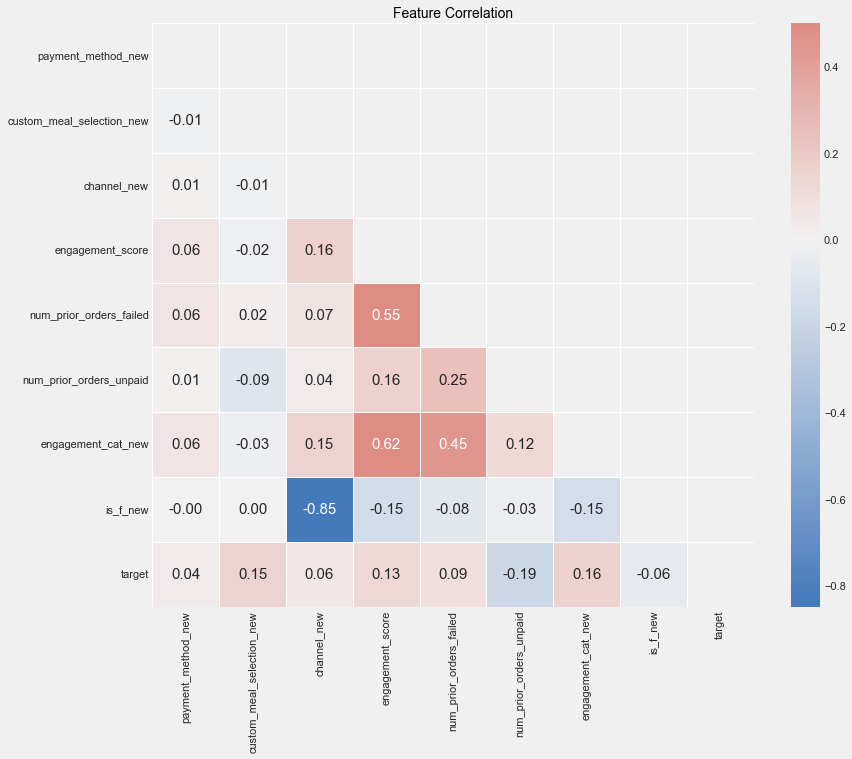

In [44]:
# heatmap with feature correlation

plt.rcParams['figure.figsize'] = (12,10)
plt.style.use('fivethirtyeight')

corrmat = df_train_final.corr()

fig, ax = plt.subplots()

mask = np.triu(np.ones_like(corrmat, dtype=bool))

cmap = sns.diverging_palette(250, 15, as_cmap=True)

sns.heatmap(corrmat, annot=True, annot_kws={"size": 15},
           fmt="0.2f", mask=mask, cmap=cmap, vmax=.5, center=0,
           square=False, linewidths=.5, cbar_kws={"shrink": 1})

ax.set_title('Feature Correlation', fontsize=14, color='black');

From the correlation heatmap above we can see that:

- `channel_new` and `is_f_new` are also inversely correlated, mainly because the latter is a feature created based on the former;
- `engagement_score` and `engagement_cat_new` have a positive correlation, also because one was built based on the other;
- `num_prior_order_failed`, `engagement_score` and `engagement_cat_new` have a positive correlation.

Now, I will be removing one of the high correlated feature in each pair based on the feature importance, i.e., I will keep the one with the highest feature importance. So I will drop the following features:

- `channel_new`;
- `engagement_cat_new`.

In [45]:
# filtering data

df_train_final = df_train.filter(['payment_method_new',
                                   'custom_meal_selection_new', 'is_f_new', 'engagement_score',
                                   'num_prior_orders_failed', 'num_prior_orders_unpaid',
                                   'target'], axis=1)

In [46]:
# spliting the data into X (independent variables) and y (dependent variable - target)

y = df_train_final['target']
X = df_train_final.drop(columns = 'target').values

### Class Imbalance

In [47]:
# checking the proportion of target variable

c = df_train_final['target'].value_counts()
c

1    18195
0     1325
Name: target, dtype: int64

From above we can see that data is completely unbalanced and we will need to create a class weight function before running the Random Forest predictive model, since this model is built on decision trees and they are sensitive to class imbalanc. Each tree is built on a "bag", and each bag is an uniform random sample from the data (with replacement). Therefore each tree will be biased in the same direction and magnitude (on average) by class imbalance.

In [48]:
# class weight function

def wts(y):
    c0, c1 = np.bincount(y)
    w0 = (1/c0)*(len(y))/2
    w1 = (1/c1)*(len(y))/2
    return {0: w0, 1: w1}

In [49]:
class_weight = wts(y)
class_weight

{0: 7.366037735849056, 1: 0.5364111019510855}

In [50]:
class_weight[0]*c[0], class_weight[1]*c[1]

(9759.999999999998, 9760.000000000002)

In [51]:
# Splitting the train dataset into training and testing data.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

### Random Forest

In [52]:
rfc_param_grid = {
    "n_estimators": [200, 300, 400],
    "max_features": ["sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [10, 20, 30, 40]    
}

In [53]:
rfc = RandomForestClassifier(random_state=1, class_weight=class_weight, n_jobs=-1)

cv_rfc = RandomizedSearchCV(
    estimator=rfc, param_distributions=rfc_param_grid, cv=3, scoring="roc_auc", n_iter=50)
cv_rfc.fit(X_train, y_train)

print(log_loss(y_train, cv_rfc.predict_proba(X_train)))
print(log_loss(y_test, cv_rfc.predict_proba(X_test)))

0.5092368661106984
0.5104958945114854


In [54]:
model = cv_rfc

In [55]:
model.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 4,
 'criterion': 'entropy'}

In [56]:
model.predict_proba(X_train)

array([[0.24250216, 0.75749784],
       [0.4356902 , 0.5643098 ],
       [0.74915671, 0.25084329],
       ...,
       [0.31853749, 0.68146251],
       [0.33139105, 0.66860895],
       [0.15960098, 0.84039902]])

### Precision and Recall for train data

In [57]:
# Threshold = 0,5
y_pred_tr = model.predict_proba(X_train)[:,1]
y_class_tr = [1 if y >= 0.5 else 0 for y in y_pred_tr]

from sklearn.metrics import confusion_matrix

print("Prec:", precision_score(y_train, y_class_tr))
print("Rec:", recall_score(y_train, y_class_tr))
print()

cm_tr = confusion_matrix(y_train, y_class_tr)
print(cm_tr)

Prec: 0.9775426689290349
Rec: 0.7693032754693269

[[ 708  225]
 [2937 9794]]


### Precision and Recall for test data from train data

In [58]:
# Threshold = 0,5
y_pred_ts = model.predict_proba(X_test)[:,1]
y_class_ts = [1 if y >= 0.5 else 0 for y in y_pred_ts]

from sklearn.metrics import confusion_matrix

print("Prec:", precision_score(y_test, y_class_ts))
print("Rec:", recall_score(y_test, y_class_ts))
print()

cm_ts = confusion_matrix(y_test, y_class_ts)
print(cm_ts)

Prec: 0.9769606702350477
Rec: 0.7683016105417276

[[ 293   99]
 [1266 4198]]


### ROC and AUC for train data

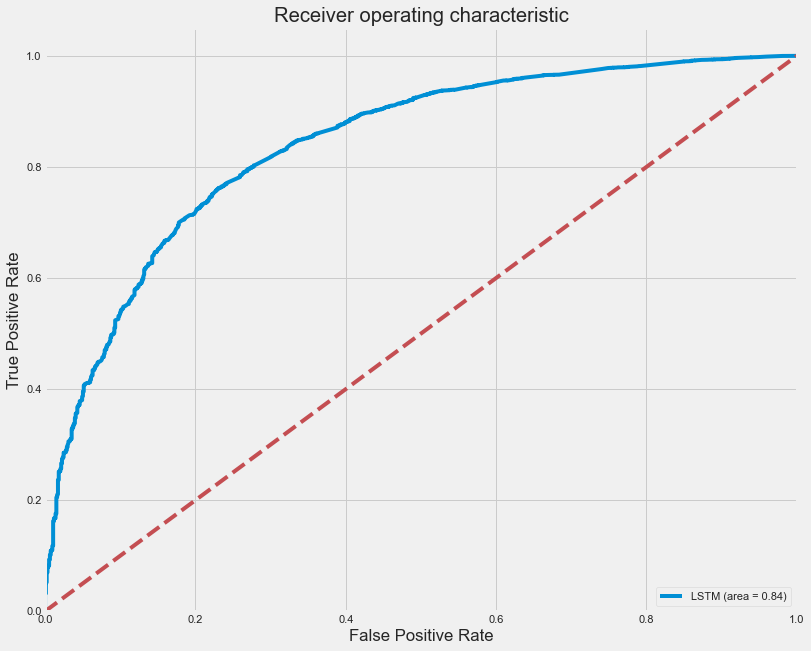

In [59]:
nn_roc_auc = roc_auc_score(y_train, y_pred_tr)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_tr)
plt.figure()
plt.title("Train")
plt.plot(fpr, tpr, label="LSTM (area = %0.2f)" % nn_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

### ROC and AUC for test data from train data

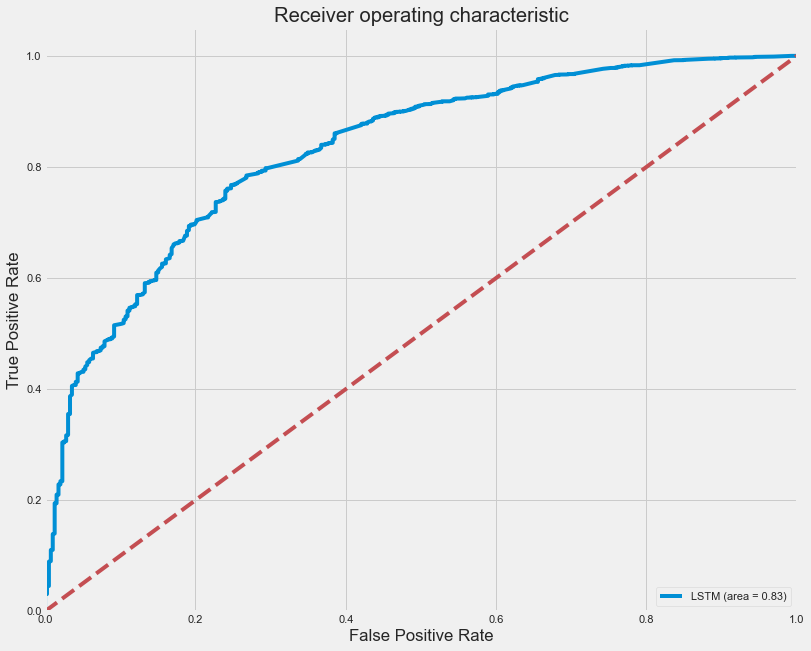

In [60]:
nn_roc_auc = roc_auc_score(y_test, y_pred_ts)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ts)
plt.figure()
plt.plot(fpr, tpr, label="LSTM (area = %0.2f)" % nn_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [61]:
max_mult = {}
F1 = {}

for i in np.arange(0, 1, 0.05):
    y_class_ts = [1 if y >= i else 0 for y in y_pred_ts]
    y_class_ts_N = [1 if y < i else 0 for y in y_pred_ts]

    print("Threshold = " + str(i) + " - Prec:", precision_score(y_test, y_class_ts))
    print("Threshold = " + str(i) + " - Prec_N:", precision_score(y_test, y_class_ts_N))
    print("Threshold = " + str(i) + " - Rec:", recall_score(y_test, y_class_ts))
    print()

    max_mult[str(i)] = precision_score(y_test, y_class_ts) * recall_score(
        y_test, y_class_ts
    )
    F1[str(i)] = (
        2
        * (precision_score(y_test, y_class_ts) * recall_score(y_test, y_class_ts))
        / (precision_score(y_test, y_class_ts) + recall_score(y_test, y_class_ts))
    )

print(max_mult)
print()
print(F1)

Threshold = 0.0 - Prec: 0.9330601092896175
Threshold = 0.0 - Prec_N: 0.0
Threshold = 0.0 - Rec: 1.0

Threshold = 0.05 - Prec: 0.9330601092896175
Threshold = 0.05 - Prec_N: 0.0
Threshold = 0.05 - Rec: 1.0

Threshold = 0.1 - Prec: 0.9330601092896175
Threshold = 0.1 - Prec_N: 0.0
Threshold = 0.1 - Rec: 1.0

Threshold = 0.15000000000000002 - Prec: 0.9381674130210127
Threshold = 0.15000000000000002 - Prec_N: 0.34
Threshold = 0.15000000000000002 - Rec: 0.9968887262079063

Threshold = 0.2 - Prec: 0.9421473245309242
Threshold = 0.2 - Prec_N: 0.41
Threshold = 0.2 - Rec: 0.9924963396778916

Threshold = 0.25 - Prec: 0.9518311383727224
Threshold = 0.25 - Prec_N: 0.6006389776357828
Threshold = 0.25 - Rec: 0.9655929721815519

Threshold = 0.30000000000000004 - Prec: 0.9556511976047904
Threshold = 0.30000000000000004 - Prec_N: 0.697265625
Threshold = 0.30000000000000004 - Rec: 0.9346632503660323

Threshold = 0.35000000000000003 - Prec: 0.962253193960511
Threshold = 0.35000000000000003 - Prec_N: 0.7144

### Kolmogorov-Smirnov

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

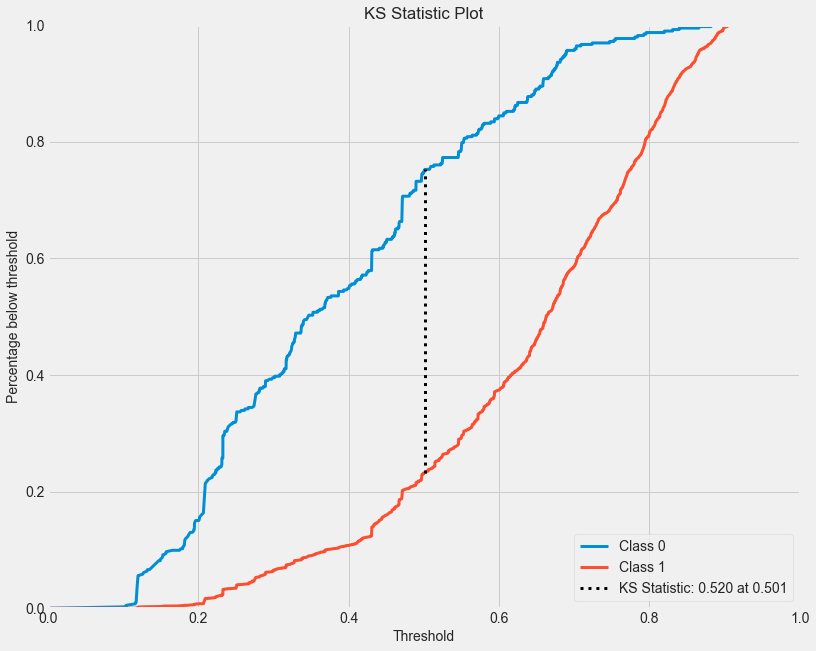

In [62]:
plot_ks_statistic(y_test,  model.predict_proba(X_test))

# 5. Using test data to make predictions with previous model

In [63]:
df_test.head()

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating
0,6,17266,20200229,2020-W10,Cancelled,NaN,X,Unknown,B,O,3,1,0,NaN
1,7,10494,20200301,2020-W10,Paid,15.0,W,Yes,D,O,29,14,0,4.0
2,8,10384,20200303,2020-W10,Paid,101.0,Z,Yes,B,S,17,9,0,NaN
3,9,3396,20200303,2020-W10,Paid,1.0,W,Yes,F,O,242,3,0,NaN
4,13,1146,20200302,2020-W10,Paid,22.0,Z,Yes,B,O,226,102,0,NaN


Let's run data_quality and data_clean functions to df_test as follows:

In [64]:
# checking data quality for test data

data_quality(df_test)

The dataset contais 4998 rows and 14 columns

Missing values:

The column time_to_pay contains 529 null values ( 10.58 % )
The column avg_recipe_rating contains 3331 null values ( 66.65 % )


Duplicated rows:

There is/are 0 duplicated row(s)


Unique values of some categorical features:

The column final_payment_status has the following unique values: ['Cancelled' 'Paid' 'Unpaid' 'Other' 'Refunded']
The column payment_method has the following unique values: ['X' 'W' 'Z' 'V' 'Y']
The column custom_meal_selection has the following unique values: ['Unknown' 'Yes' 'No']
The column state has the following unique values: ['B' 'D' 'F' 'G' 'A' 'E' 'New York' 'C' '<error>']
The column channel has the following unique values: ['O' 'S' 'F2' 'A1' 'D' 'E' 'H' 'F1' 'P' 'A2' 'F3' 'I']


Checking state unique value counts:

B           1352
F           1277
D           1257
G            652
E            290
A            107
C             53
<error>        9
New York       1
Name: state, dtype: int64


In [65]:
# performing data cleaning on test data

df_test = data_clean(df_test)

In [66]:
df_test.head()

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating
0,6,17266,2020-02-29,2020-W10,Cancelled,NaN,X,Unknown,B,O,3,1,0,NaN
1,7,10494,2020-03-01,2020-W10,Paid,15.0,W,Yes,D,O,29,14,0,4.0
2,8,10384,2020-03-03,2020-W10,Paid,101.0,Z,Yes,B,S,17,9,0,NaN
3,9,3396,2020-03-03,2020-W10,Paid,1.0,W,Yes,F,O,242,3,0,NaN
4,13,1146,2020-03-02,2020-W10,Paid,22.0,Z,Yes,B,O,226,102,0,NaN


In [67]:
# function to create ever_rated_recipe and is_f binary columns

feature_c(df_test)

In [68]:
# function to create a binary variable to be the target

df_test['target'] = df_test['final_payment_status'].apply(target_bin)

In [69]:
# function to bucket engagement score into Low/High

df_test['engagement_cat'] = df_test['engagement_score'].apply(engagement_cat)

In [70]:
# transforming categorical features into numerical before running the predictive model

df_test = cat_features(df_test)

In [71]:
df_test.head()

,customer_id,order_number,delivery_date,delivery_week,final_payment_status,time_to_pay,payment_method,custom_meal_selection,state,channel,engagement_score,num_prior_orders_failed,num_prior_orders_unpaid,avg_recipe_rating,ever_rated_recipe,is_f,target,engagement_cat,delivery_week_new,payment_method_new,custom_meal_selection_new,state_new,channel_new,engagement_cat_new,ever_rated_recipe_new,is_f_new
0,6,17266,2020-02-29,2020-W10,Cancelled,NaN,X,Unknown,B,O,3,1,0,NaN,False,False,1,Low,0,1,2,2,7,0,0,0
1,7,10494,2020-03-01,2020-W10,Paid,15.0,W,Yes,D,O,29,14,0,4.0,True,False,1,High,0,0,1,1,7,1,1,0
2,8,10384,2020-03-03,2020-W10,Paid,101.0,Z,Yes,B,S,17,9,0,NaN,False,False,1,High,0,2,1,2,6,1,0,0
3,9,3396,2020-03-03,2020-W10,Paid,1.0,W,Yes,F,O,242,3,0,NaN,False,False,1,High,0,0,1,4,7,1,0,0
4,13,1146,2020-03-02,2020-W10,Paid,22.0,Z,Yes,B,O,226,102,0,NaN,False,False,1,High,0,2,1,2,7,1,0,0


In [72]:
# feature selection as built on the model

df_test_final = df_test.filter(['payment_method_new',
                                   'custom_meal_selection_new', 'is_f_new', 'engagement_score',
                                   'num_prior_orders_failed', 'num_prior_orders_unpaid',
                                   'target'], axis=1)

In [73]:
# dividing test data into dependent and independent variables

yt = df_test_final['target']
Xt = df_test_final.drop(columns = 'target').values

### Precision, Recall and Confusion Matrix for test data

In [74]:
# Threshold = 0,5
y_pred_ts = model.predict_proba(Xt)[:,1]
y_class_ts = [1 if yt >= 0.6 else 0 for yt in y_pred_ts]

from sklearn.metrics import confusion_matrix

print("Prec:", precision_score(yt, y_class_ts))
print("Rec:", recall_score(yt, y_class_ts))
print()

cm_ts = confusion_matrix(yt, y_class_ts)
print(cm_ts)

Prec: 0.9804459691252144
Rec: 0.6240174672489083

[[ 305   57]
 [1722 2858]]


In [75]:
y_pred_ts

array([0.65488936, 0.79197725, 0.78299769, ..., 0.62645899, 0.64255741,
       0.74503549])

In [76]:
model.predict_proba(Xt)[:,1]

array([0.65488936, 0.79197725, 0.78299769, ..., 0.62645899, 0.64255741,
       0.74503549])

### ROC and AUC for test data

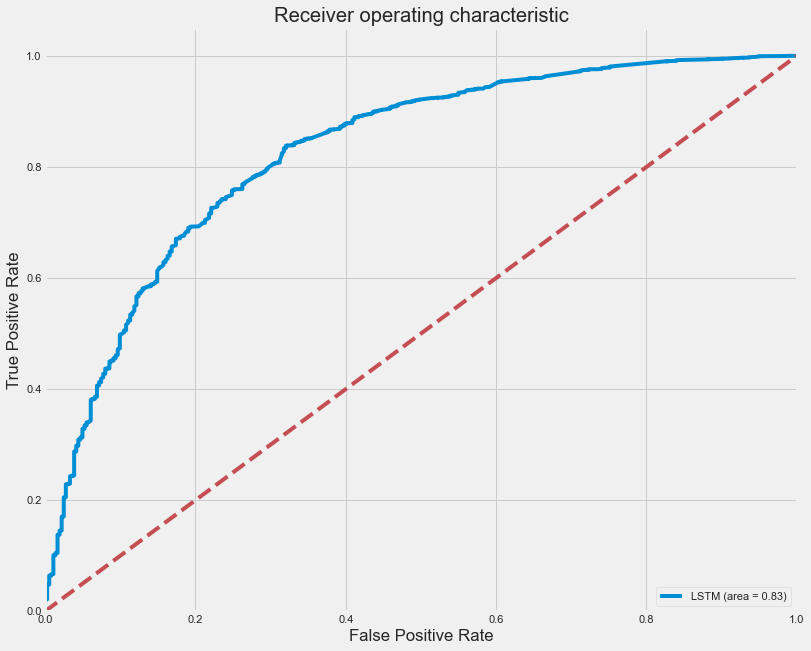

In [77]:
nn_roc_auc = roc_auc_score(yt, y_pred_ts)
fpr, tpr, thresholds = roc_curve(yt, y_pred_ts)
plt.figure()
plt.plot(fpr, tpr, label="LSTM (area = %0.2f)" % nn_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [78]:
max_mult = {}
F1 = {}

for i in np.arange(0, 1, 0.05):
    y_class_ts = [1 if yt >= i else 0 for yt in y_pred_ts]
    y_class_ts_N = [1 if yt < i else 0 for yt in y_pred_ts]

    print("Threshold = " + str(i) + " - Acc:", accuracy_score(yt, y_class_ts))
    print("Threshold = " + str(i) + " - Prec:", precision_score(yt, y_class_ts))
    print("Threshold = " + str(i) + " - Prec_N:", precision_score(yt, y_class_ts_N))
    print("Threshold = " + str(i) + " - Rec:", recall_score(yt, y_class_ts))
    print()

    max_mult[str(i)] = precision_score(yt, y_class_ts) * recall_score(
        yt, y_class_ts
    )
    F1[str(i)] = (
        2
        * (precision_score(yt, y_class_ts) * recall_score(yt, y_class_ts))
        / (precision_score(yt, y_class_ts) + recall_score(yt, y_class_ts))
    )

print(max_mult)
print()
print(F1)

Threshold = 0.0 - Acc: 0.9267503035208418
Threshold = 0.0 - Prec: 0.9267503035208418
Threshold = 0.0 - Prec_N: 0.0
Threshold = 0.0 - Rec: 1.0

Threshold = 0.05 - Acc: 0.9267503035208418
Threshold = 0.05 - Prec: 0.9267503035208418
Threshold = 0.05 - Prec_N: 0.0
Threshold = 0.05 - Rec: 1.0

Threshold = 0.1 - Acc: 0.9267503035208418
Threshold = 0.1 - Prec: 0.9267503035208418
Threshold = 0.1 - Prec_N: 0.0
Threshold = 0.1 - Rec: 1.0

Threshold = 0.15000000000000002 - Acc: 0.9293808174828004
Threshold = 0.15000000000000002 - Prec: 0.9332377636698751
Threshold = 0.15000000000000002 - Prec_N: 0.3898305084745763
Threshold = 0.15000000000000002 - Rec: 0.9949781659388647

Threshold = 0.2 - Acc: 0.9303925536220153
Threshold = 0.2 - Prec: 0.9381464625568887
Threshold = 0.2 - Prec_N: 0.4166666666666667
Threshold = 0.2 - Rec: 0.990174672489083

Threshold = 0.25 - Acc: 0.914609469850263
Threshold = 0.25 - Prec: 0.9498052790999567
Threshold = 0.25 - Prec_N: 0.59375
Threshold = 0.25 - Rec: 0.95851528384

### Main Conclusion: Identifying that the highest accuracy is at threshold 0.2 and assuming the cost of false positive and false negative are the same. There will be a maximum of 0.5% gain using this model.

### Kolmogorov-Smirnov

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

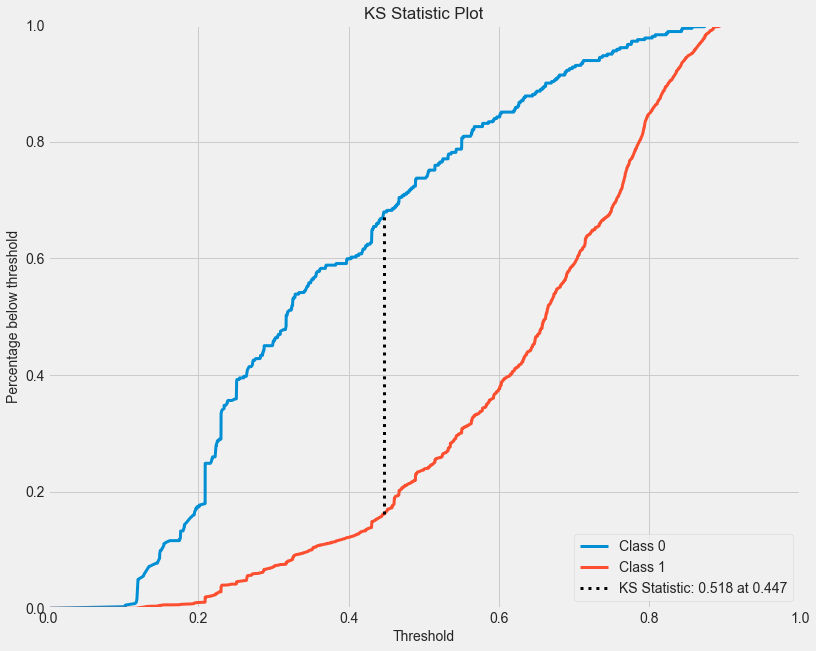

In [79]:
plot_ks_statistic(yt,  model.predict_proba(Xt))

 KS is stable for training and test data and the value of 0.518 is considerably high.